In [1]:
import os
import numpy as np
import scipy.io as sio
import time

In [2]:
stim_file_name = r'/kaggle/input/surfaceinvariance/occlusion_set1.mat'
stim_data = sio.loadmat(stim_file_name)

In [18]:
## 14 images of shape (251, 251, 3)

stim_data['stim'][13][0]
stims = stim_data['stim'].flatten()

(251, 251, 3)

In [19]:
# Networks
types = ['imagenet-vgg-verydeep-16', 'imagenet-matconvnet-vgg-verydeep-16.mat', 'imagenet-vgg-verydeep-16_randn.mat', 'imagenet-vgg-face','imagenet-caffe-alex','imagenet-googlenet-dag','imagenet-resnet-50-dag','imagenet-resnet-152-dag']
dagg_flag = [0, 0, 0, 0, 0, 1, 1, 1]
network_short_name = ['VGG-16', 'mat.VGG-16', 'VGG-16 randn', 'VGG-face', 'Alexnet', 'Goolgenet', 'ResNet 50', 'ResNet 152']

In [20]:
import torch
import torch.nn.functional as F
import torch.nn as nn

def vl_simplenn(net, x, res=None):

#     print(x)
    n=len(net.features) + len(net.classifier)
    print("LEn:",n)
    if (res is None):
        res = [{'x': None} for _ in range(n + 1)]

    res[0]['x'] = x
    i=0
    for (name, layer) in net.named_children():
        
        for  (sub_name, sub_layer) in (layer.named_children()):
            print("Iteration:",i)
#             print(sub_layer)
            ltype=sub_layer.__class__.__name__
            print(f"  Type: {sub_layer.__class__.__name__}")

    # res[i]['time'] = time.time()
            if ltype == 'Conv2d':
                print(res[i]['x'].shape,sub_layer.weight.shape,sub_layer.bias.shape)
                res[i + 1]['x'] = F.conv2d(res[i]['x'], sub_layer.weight,sub_layer.bias,
                            padding=sub_layer.padding, stride=sub_layer.stride, dilation=sub_layer.dilation)

            elif ltype == 'MaxPool2d':
                res[i + 1]['x'] = F.max_pool2d(res[i]['x'], padding=sub_layer.padding, stride=sub_layer.stride,kernel_size=sub_layer.kernel_size)
            elif ltype=='Linear':
                linear_layer = nn.Linear(res[i]['x'].flatten().shape[0], 4096)
                output_tensor = linear_layer(res[i]['x'].flatten())
                res[i + 1]['x'] = output_tensor.to(torch.float32)
#                 temp= nn.Linear(res[i]['x'].flatten().shape[0], 4096)
#                 res[i + 1]['x'] = torch.tensor(temp),dtype=torch.float32
            elif ltype=='Dropout':
                i=i-1
#                 dropout_layer = CustomDropout(p=0.5)
#                 print(dropout_layer)
#                 res[i + 1]['x'] = dropout_layer
            elif ltype== 'ReLU':
                # if l['leak'] > 0:
                #     leak = {'leak': l['leak']}
                # else:
                leak = {}

                if res[i]['x'] is not None:
                    res[i + 1]['x'] = F.relu(res[i]['x'], **leak)
                else:
                    res[i + 1]['x'] = F.relu(res[i + 1]['x'], **leak)
            i+=1

    return res

In [25]:
import torch
import torchvision.transforms as transforms
from torchvision.models import vgg16
from PIL import Image
import numpy as np

def extract_features(stim_data, types, dagg_flag, run_path, pretrained=True):
    # Load the VGG16 model
    model = vgg16(pretrained=pretrained)
    model.eval()  # Set the model to evaluation mode

    # Define the preprocessing transformations
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Extract the image data from the loaded dictionary
    #stim_images = stim_data['stim'][0]
    nimages = len(stim_data)
    print(nimages)
    if dagg_flag==0:
        features = []
        for ind in range(nimages):
            # Convert the numpy array to PIL Image
            image_array = stim_data[ind].astype(np.uint8)
            if len(image_array.shape) < 3:
                image_array = np.stack((image_array,) * 3, axis=-1)
            image = Image.fromarray(image_array)

        # Preprocess and normalize the image
            image_tensor = preprocess(image).unsqueeze(0)
            print(image_tensor.shape)
                # Perform inference using the model
            with torch.no_grad():
                output = model(image_tensor)

            # Append the features to the list
            features.append(vl_simplenn(model, image_tensor))
        print('Done')
    return features

In [32]:
reference_mi = np.array([0.67, 0.6])  # Basic Effect, Depth Ordering
reference_name = ['Rensink & Enns 1998', 'Rensink & Enns 1998']
legend_name = ['Occlusion Effect', 'Effect of depth Ordering']
y_label = 'Occlusion Index'
run_path = r'/'

In [33]:
print('\n Extracting Features from VGG-16\n')
features = extract_features(stims, types[0], dagg_flag[0], run_path, pretrained=True)


 Extracting Features from VGG-16



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 96.3MB/s] 


14
torch.Size([1, 3, 224, 224])
LEn: 38
Iteration: 0
  Type: Conv2d
torch.Size([1, 3, 224, 224]) torch.Size([64, 3, 3, 3]) torch.Size([64])
Iteration: 1
  Type: ReLU
Iteration: 2
  Type: Conv2d
torch.Size([1, 64, 224, 224]) torch.Size([64, 64, 3, 3]) torch.Size([64])
Iteration: 3
  Type: ReLU
Iteration: 4
  Type: MaxPool2d
Iteration: 5
  Type: Conv2d
torch.Size([1, 64, 112, 112]) torch.Size([128, 64, 3, 3]) torch.Size([128])
Iteration: 6
  Type: ReLU
Iteration: 7
  Type: Conv2d
torch.Size([1, 128, 112, 112]) torch.Size([128, 128, 3, 3]) torch.Size([128])
Iteration: 8
  Type: ReLU
Iteration: 9
  Type: MaxPool2d
Iteration: 10
  Type: Conv2d
torch.Size([1, 128, 56, 56]) torch.Size([256, 128, 3, 3]) torch.Size([256])
Iteration: 11
  Type: ReLU
Iteration: 12
  Type: Conv2d
torch.Size([1, 256, 56, 56]) torch.Size([256, 256, 3, 3]) torch.Size([256])
Iteration: 13
  Type: ReLU
Iteration: 14
  Type: Conv2d
torch.Size([1, 256, 56, 56]) torch.Size([256, 256, 3, 3]) torch.Size([256])
Iteration: 15

In [34]:
print('\n Extracting Features from VGG-16 Random\n')
features_rand = extract_features(stims, types[2], dagg_flag[2], run_path, pretrained=False)


 Extracting Features from VGG-16 Random



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


14
torch.Size([1, 3, 224, 224])
LEn: 38
Iteration: 0
  Type: Conv2d
torch.Size([1, 3, 224, 224]) torch.Size([64, 3, 3, 3]) torch.Size([64])
Iteration: 1
  Type: ReLU
Iteration: 2
  Type: Conv2d
torch.Size([1, 64, 224, 224]) torch.Size([64, 64, 3, 3]) torch.Size([64])
Iteration: 3
  Type: ReLU
Iteration: 4
  Type: MaxPool2d
Iteration: 5
  Type: Conv2d
torch.Size([1, 64, 112, 112]) torch.Size([128, 64, 3, 3]) torch.Size([128])
Iteration: 6
  Type: ReLU
Iteration: 7
  Type: Conv2d
torch.Size([1, 128, 112, 112]) torch.Size([128, 128, 3, 3]) torch.Size([128])
Iteration: 8
  Type: ReLU
Iteration: 9
  Type: MaxPool2d
Iteration: 10
  Type: Conv2d
torch.Size([1, 128, 56, 56]) torch.Size([256, 128, 3, 3]) torch.Size([256])
Iteration: 11
  Type: ReLU
Iteration: 12
  Type: Conv2d
torch.Size([1, 256, 56, 56]) torch.Size([256, 256, 3, 3]) torch.Size([256])
Iteration: 13
  Type: ReLU
Iteration: 14
  Type: Conv2d
torch.Size([1, 256, 56, 56]) torch.Size([256, 256, 3, 3]) torch.Size([256])
Iteration: 15

In [55]:
features_rand[13][36]['x'].shape

torch.Size([4096])

In [56]:
import numpy as np

def check_occlusion(features):
    nL = len(features[0]) - 1  # Skipping the last layers

    # Initialize matrices
    M_basic_effect = np.zeros((nL, 2))
    M_dept_ordering = np.zeros((nL, 4))

    # Check the basic effect
    for L in range(nL):
        # First set
        img1 = np.ravel(features[0][L]['x'])
        img2 = np.ravel(features[1][L]['x'])
        img3 = np.ravel(features[2][L]['x'])
        d12 = np.linalg.norm(img1 - img2, 1)
        d13 = np.linalg.norm(img1 - img3, 1)
        M_basic_effect[L, 0] = (d13 - d12) / (d13 + d12)

        # 180 degree rotated set
        img4 = np.ravel(features[3][L]['x'])
        img5 = np.ravel(features[4][L]['x'])
        img6 = np.ravel(features[5][L]['x'])
        d45 = np.linalg.norm(img4 - img5, 1)
        d46 = np.linalg.norm(img4 - img6, 1)
        M_basic_effect[L, 1] = (d46 - d45) / (d46 + d45)

    # Check the effect of depth ordering
    for L in range(nL):
        # First control set
        img7 = np.ravel(features[6][L]['x'])
        img8 = np.ravel(features[7][L]['x'])
        img2 = np.ravel(features[1][L]['x'])
        d78 = np.linalg.norm(img7 - img8, 2)
        d72 = np.linalg.norm(img7 - img2, 2)
        M_dept_ordering[L, 0] = (d78 - d72) / (d78 + d72)

        # 180 degree rotated set
        img9 = np.ravel(features[8][L]['x'])
        img10 = np.ravel(features[9][L]['x'])
        img5 = np.ravel(features[4][L]['x'])
        d910 = np.linalg.norm(img9 - img10, 1)
        d95 = np.linalg.norm(img9 - img5, 1)
        M_dept_ordering[L, 1] = (d910 - d95) / (d910 + d95)

        # Second control set
        img2 = np.ravel(features[1][L]['x'])
        img7 = np.ravel(features[6][L]['x'])
        img11 = np.ravel(features[10][L]['x'])
        d27 = np.linalg.norm(img2 - img7, 1)
        d211 = np.linalg.norm(img2 - img11, 1)
        M_dept_ordering[L, 2] = (d211 - d27) / (d211 + d27)

        # 180 rotated second control set
        img5 = np.ravel(features[4][L]['x'])
        img9 = np.ravel(features[8][L]['x'])
        img12 = np.ravel(features[11][L]['x'])
        d59 = np.linalg.norm(img5 - img9, 1)
        d512 = np.linalg.norm(img5 - img12, 1)
        M_dept_ordering[L, 3] = (d512 - d59) / (d512 + d59)

    # Type of Completion
    M_type_of_completion = np.zeros((nL, 2))
    for L in range(nL):
        # First control part 1
        img2 = np.ravel(features[1][L]['x'])
        img3 = np.ravel(features[2][L]['x'])
        img13 = np.ravel(features[12][L]['x'])
        d23 = np.linalg.norm(img2 - img3, 1)
        d213 = np.linalg.norm(img2 - img13, 1)
        M_type_of_completion[L, 0] = (d213 - d23) / (d23 + d213)

        # First control part 2
        img11 = np.ravel(features[10][L]['x'])
        d211 = np.linalg.norm(img2 - img11, 1)
        M_type_of_completion[L, 1] = (d211 - d23) / (d23 + d211)

    # Calculate means and SEM
    mi_occlusion_mean = np.nanmean([M_basic_effect, M_dept_ordering], axis=1)
    mi_occlusion_sem = np.nanstd([M_basic_effect, M_dept_ordering], axis=1) / np.sqrt(nL)

    return mi_occlusion_mean, mi_occlusion_sem

In [ ]:
sel_index = [0, 2]
file_name = os.path.join('..', 'results', 'Supp_figure_Occlusion Index_VGG16_versus_matconvnet')
order = [0, 2, 1, 3]
mean_data = mean_data[order, :]
legend_name = [legend_name[i] for i in order]
miLayerwise_selected_mean_v1, miLayerwise_selected_sem_v1 = check_occlusion(features)
miLayerwise_selected_mean_v2, miLayerwise_selected_sem_v2 = check_occlusion(features)

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D


def layerwise_mi_figures(mean_data, sem_data, file_name, reference_mi=None, reference_name=None, legend_name=None,
                         y_label=None, shaded_region_name='Human perception', y_limits=None):
    if y_limits is None:
        y_limits = [-1, 1]

    plt.figure(figsize=(7, 4))

    # Drawing the human perception rectangle
    plt.gca().add_patch(Rectangle((1, 0), 37, 1, facecolor=[0.8, 0.8, 0.8], edgecolor='none'))

    # Naming the layers by drawing the bottom rectangles
    layer_grouping = np.array([[1, 6.45], [6.55, 11.45], [11.55, 18.45], [18.55, 25.45], [25.55, 32.45], [32.55, 37]])
    layer_colour = np.vstack([np.tile([0.8, 0.8, 0.8], (5, 1)), [0.5, 0.5, 0.5]])
    box_width = 0.2 / (y_limits[1] - y_limits[0])

    for ind, (start, end) in enumerate(layer_grouping):
        plt.gca().add_patch(
            Rectangle((start, y_limits[0]), end - start, box_width, facecolor=layer_colour[ind], edgecolor='none'))
        plt.text(start + 0.4, y_limits[0] + box_width / 2, ['conv-1', 'conv-2', 'conv-3', 'conv-4', 'conv-5', 'fc'][ind], color='k', fontsize=6)

    # Plotting the data
    line_colour = plt.cm.get_cmap('tab10')
    marker_size = 2
    layer_ind = np.arange(1, 38)
    # print(mean_data)
    # print(np.array(mean_data).shape)
    mean_data = np.array(mean_data)
    for ind in range(mean_data.shape[0]):
        if sem_data is not None and not np.all(np.isnan(sem_data)):
            shadedErrorBar(layer_ind, mean_data[ind], sem_data[ind], lineprops=['-', {'markerfacecolor': line_colour(ind), 'color': line_colour(ind), 'linewidth': 0.5}], transparent=True, patchSaturation=0.3)
        else:
            plt.plot(layer_ind, mean_data[ind], '-', markerfacecolor=line_colour(ind), color=line_colour(ind), linewidth=0.5)

        plt.plot(layer_ind[1:14:2], mean_data[ind, 1:14:2], 'o', markersize=marker_size,
                 markeredgecolor=line_colour(ind))
        plt.plot(layer_ind[2:15:2], mean_data[ind, 2:15:2], 'o', markersize=marker_size,
                 markeredgecolor=line_colour(ind), markerfacecolor=line_colour(ind))
        plt.plot(layer_ind[5:16:3], mean_data[ind, 5:16:3], 'd', markersize=marker_size,
                 markeredgecolor=line_colour(ind), markerfacecolor=line_colour(ind))
        plt.plot(layer_ind[32:], mean_data[ind, 32:], 's', markersize=marker_size, markeredgecolor=line_colour(ind))

    # Visual search modulation index
    if reference_mi is not None:
        if isinstance(reference_mi, (list, np.ndarray)):
            for i, mi in enumerate(reference_mi):
                plt.plot([1, 37], [mi, mi], '--', color='k', linewidth=0.5)
                plt.text(2, mi + 0.1, reference_name[i], fontsize=6)
        else:
            plt.plot([1, 37], [reference_mi, reference_mi], '--', color='k', linewidth=0.5)
            plt.text(2, reference_mi + 0.1, reference_name, fontsize=6)

    # Naming the shaded region
    plt.text(3, 0.9, shaded_region_name, fontsize=6)

    plt.xlim(0.5, 37.5)
    plt.ylim(y_limits)
    plt.xticks(range(1, 38))
    plt.yticks(np.linspace(y_limits[0], y_limits[1], 5))

    plt.xlabel('VGG-16 layers')
    plt.ylabel(y_label)

    if legend_name is not None:
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles, labels, fontsize=6, loc='best', bbox_to_anchor=(1, 1), frameon=False)

    plt.tight_layout()
  #  plt.savefig(file_name + '.pdf')
    plt.show()

/tmp/ipykernel_33/1456367342.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  line_colour = plt.cm.get_cmap('tab10')


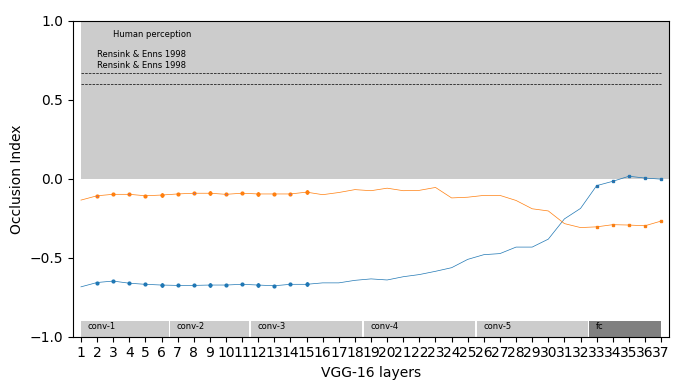

In [62]:
reference_mi = np.array([0.67, 0.6])  # Basic Effect, Depth Ordering
reference_name = ['Rensink & Enns 1998', 'Rensink & Enns 1998']
y_label = 'Occlusion Index'
file_name = r'/'
layerwise_mi_figures([miLayerwise_selected_mean_v1, miLayerwise_selected_mean_v2], sem_data, file_name, reference_mi, reference_name, ['VGG16,VGG16_rand'], y_label)